[*********************100%***********************]  1 of 1 completed


(array([[ 0.28675826,  0.27649289,  0.31899314, ...,  0.67620376,
          0.50964806,  0.84940909],
        [ 2.70072251,  2.80143566,  2.61601505, ...,  1.86735051,
         -0.80267041, -0.42974573],
        [-0.7953635 , -0.81951958, -0.81231897, ...,  0.65844967,
         -0.74923507, -0.94176518],
        ...,
        [ 1.95912848,  1.89619712,  1.88219096, ...,  0.74782575,
         -0.77979434, -0.61159215],
        [-1.74505797, -1.75094295, -1.77928512, ...,  0.57964726,
         -0.72438457, -0.95097729],
        [ 1.58076418,  1.60442601,  1.61082892, ...,  0.19420714,
         -0.77885205, -0.59426964]]),
 Date
 2018-03-16     9.655666
 2021-11-01    17.919769
 2020-11-12     8.497214
 2019-03-05     8.008782
 2017-05-16     8.981322
                 ...    
 2021-02-22    11.561784
 2021-05-05    11.681182
 2021-06-24    15.113897
 2020-05-29     5.840591
 2021-06-18    14.705952
 Name: Tomorrow Adj Close, Length: 995, dtype: float64,
              Open       High    Low

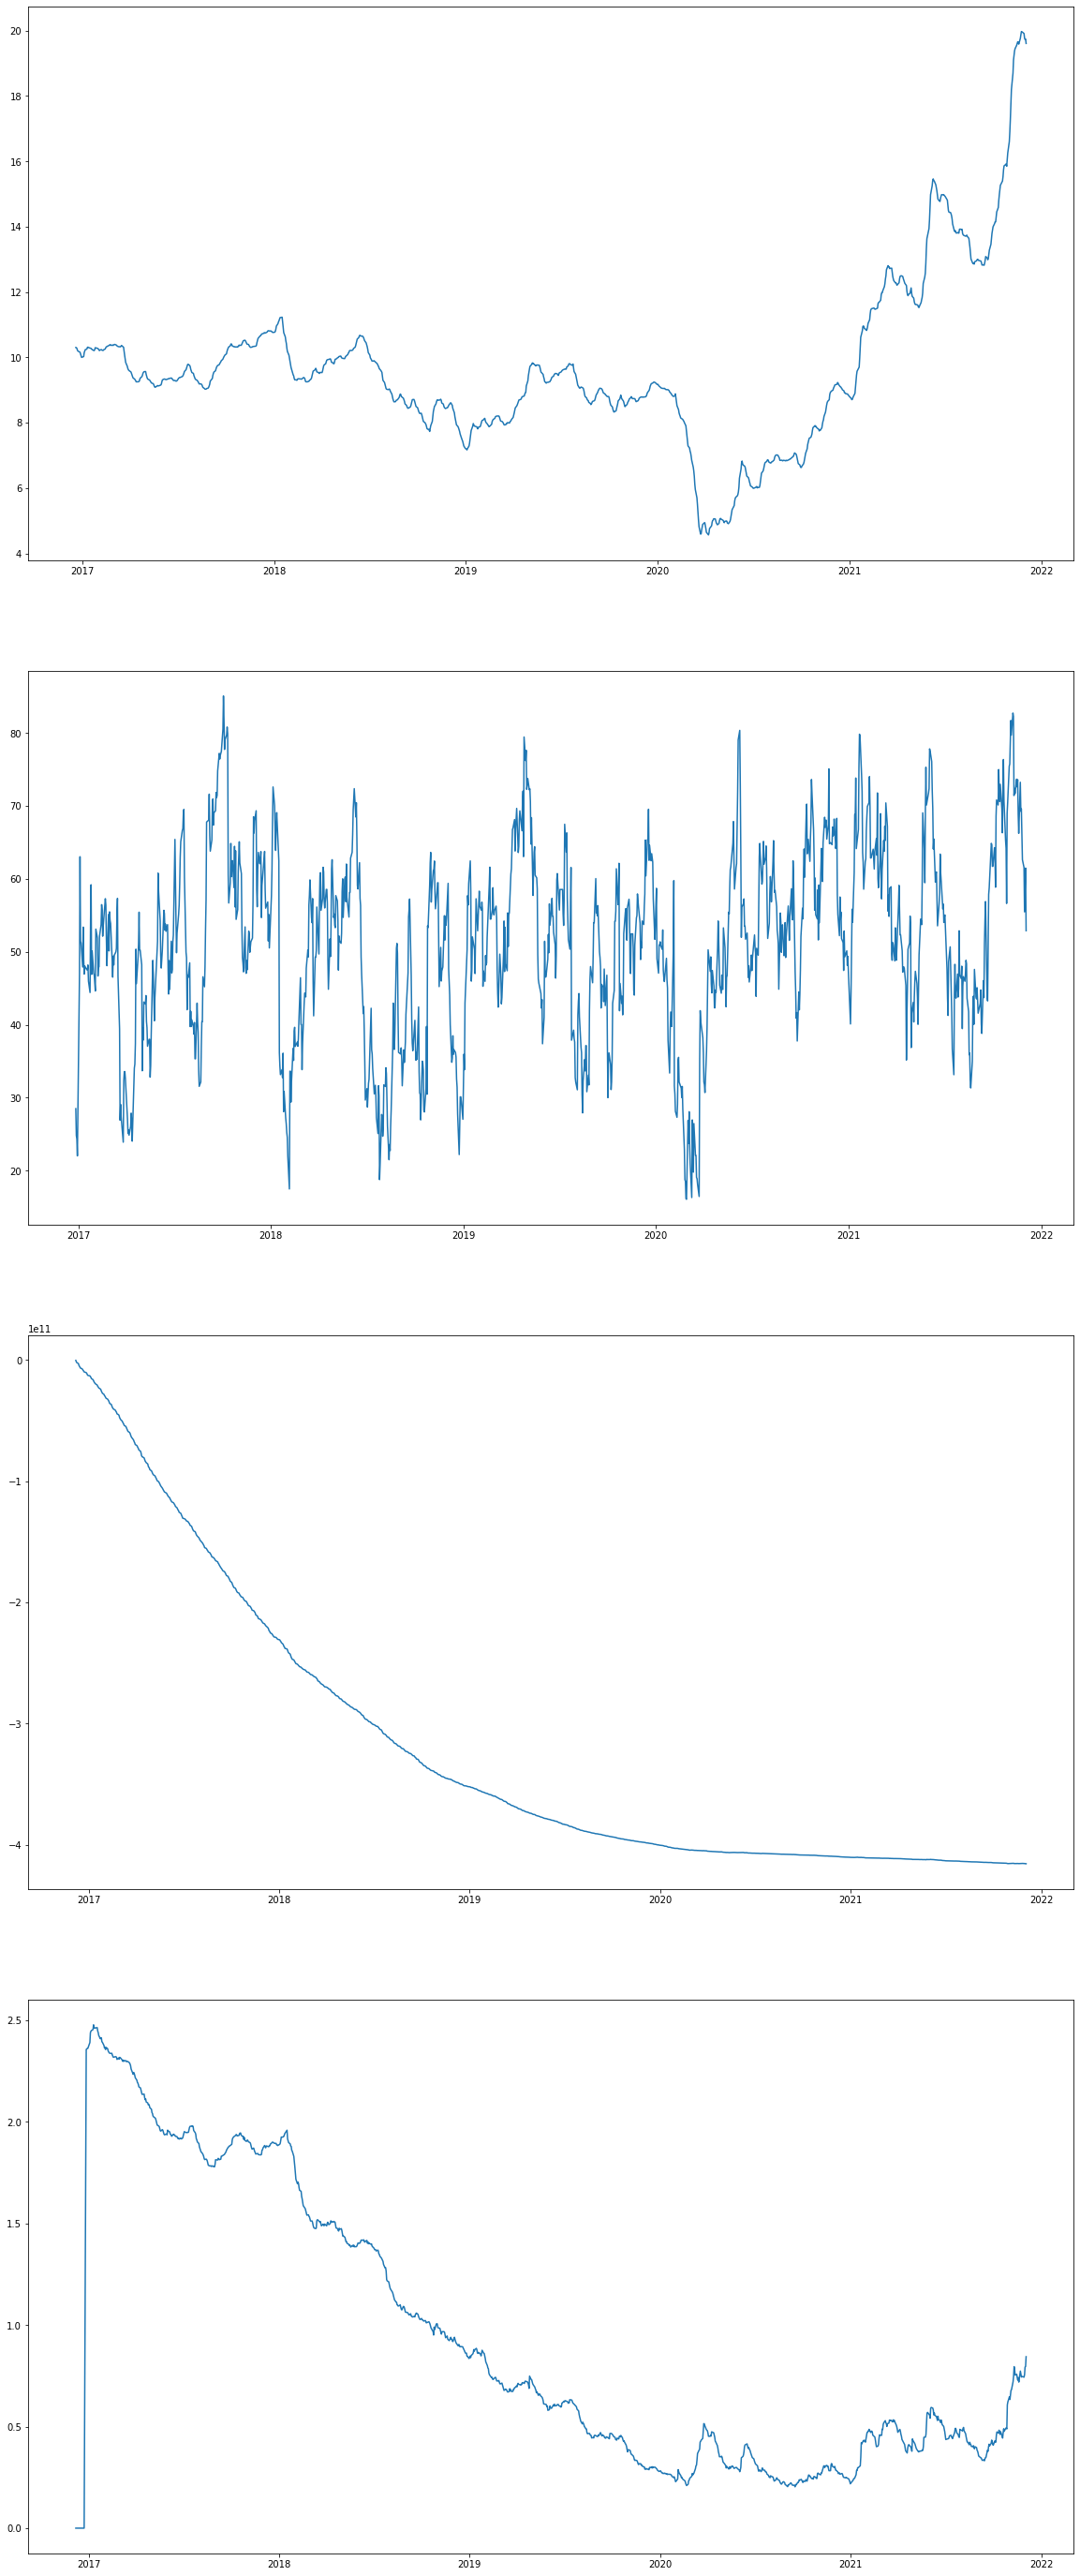

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from ta.trend import WMAIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import AccDistIndexIndicator

def ticker_data_processing(ticker, time_period):
    tick = yf.download(ticker, period=time_period)
    tickerData = tick
    
    #adjusting the Adj Close columns 
    tickerData = tickerData.drop(['Close'], axis =1)
    adjclose = tickerData['Adj Close']
    tickerData['Today Adj Close'] = adjclose
    tickerData['Adj Close'] = tickerData['Adj Close'].shift(-1)
    tickerData = tickerData.dropna()
    tickerData = tickerData.rename(columns={"Adj Close" : "Tomorrow Adj Close"})
    
    #using TA library to calculate and add TA data to the data set
    indicator_wma = WMAIndicator(close=tickerData["Today Adj Close"], window = 9)
    tickerData['WMA'] = indicator_wma.wma()
    
    indicator_rsi = RSIIndicator(close=tickerData["Today Adj Close"], window = 14)
    tickerData['RSI'] = indicator_rsi.rsi()
    
    indicator_adi = AccDistIndexIndicator(high=tickerData["High"], low=tickerData["Low"], close=tickerData["Today Adj Close"], volume=tickerData["Volume"])
    tickerData['ADI'] = indicator_adi.acc_dist_index()
    
    indicator_atr = AverageTrueRange(high=tickerData["High"], low=tickerData["Low"], close=tickerData["Today Adj Close"], window = 14)
    tickerData['ATR'] = indicator_atr.average_true_range()
    
    #graphing the TA indicators
    fig, grph = plt.subplots(4, figsize =(20, 50))
    grph[0].plot(tickerData['WMA'])
    grph[1].plot(tickerData['RSI'])
    grph[2].plot(tickerData['ADI'])
    grph[3].plot(tickerData['ATR'])
    
    #drops N/A
    tickerData = tickerData.dropna()
    
    #splitting the test and train data and dropping volume from both
    train_set, test_set = train_test_split(tickerData, test_size=0.2, random_state=42)
    train_set = train_set.drop(['Volume'], axis=1)
    test_set = test_set.drop(['Volume'], axis=1)
    
    
    #setting up the scaler, can be swapped between MinMaxScaler and StandardScaler
    scale = ['Open', 'High', 'Low', 'Today Adj Close']
    scaler = StandardScaler()

    train_set_features = train_set.drop(["Tomorrow Adj Close"], axis=1)
    train_set_labels = train_set['Tomorrow Adj Close'].copy()
    feature_transform = scaler.fit_transform(train_set_features[scale])
    train_prepared = pd.DataFrame(columns=scale, data=feature_transform, index=train_set_features.index)
    
    test_set_features = train_set.drop(['Tomorrow Adj Close'], axis=1)
    test_set_labels = train_set['Tomorrow Adj Close'].copy()
    
    #scaling the data
    train_prepared = scaler.fit_transform(train_set)
    test_set_labels = scaler.transform(test_set)
    
    
    return train_prepared, train_set_labels, test_set_features, test_set_labels 

ticker_data_processing('F', '5y')
    

[*********************100%***********************]  1 of 1 completed


/home/cooper/ml/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cooper/ml/my_env/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LinearSVR was fitted without feature names
  warnings.warn(


ValueError: X has 8 features, but LinearSVR is expecting 9 features as input.

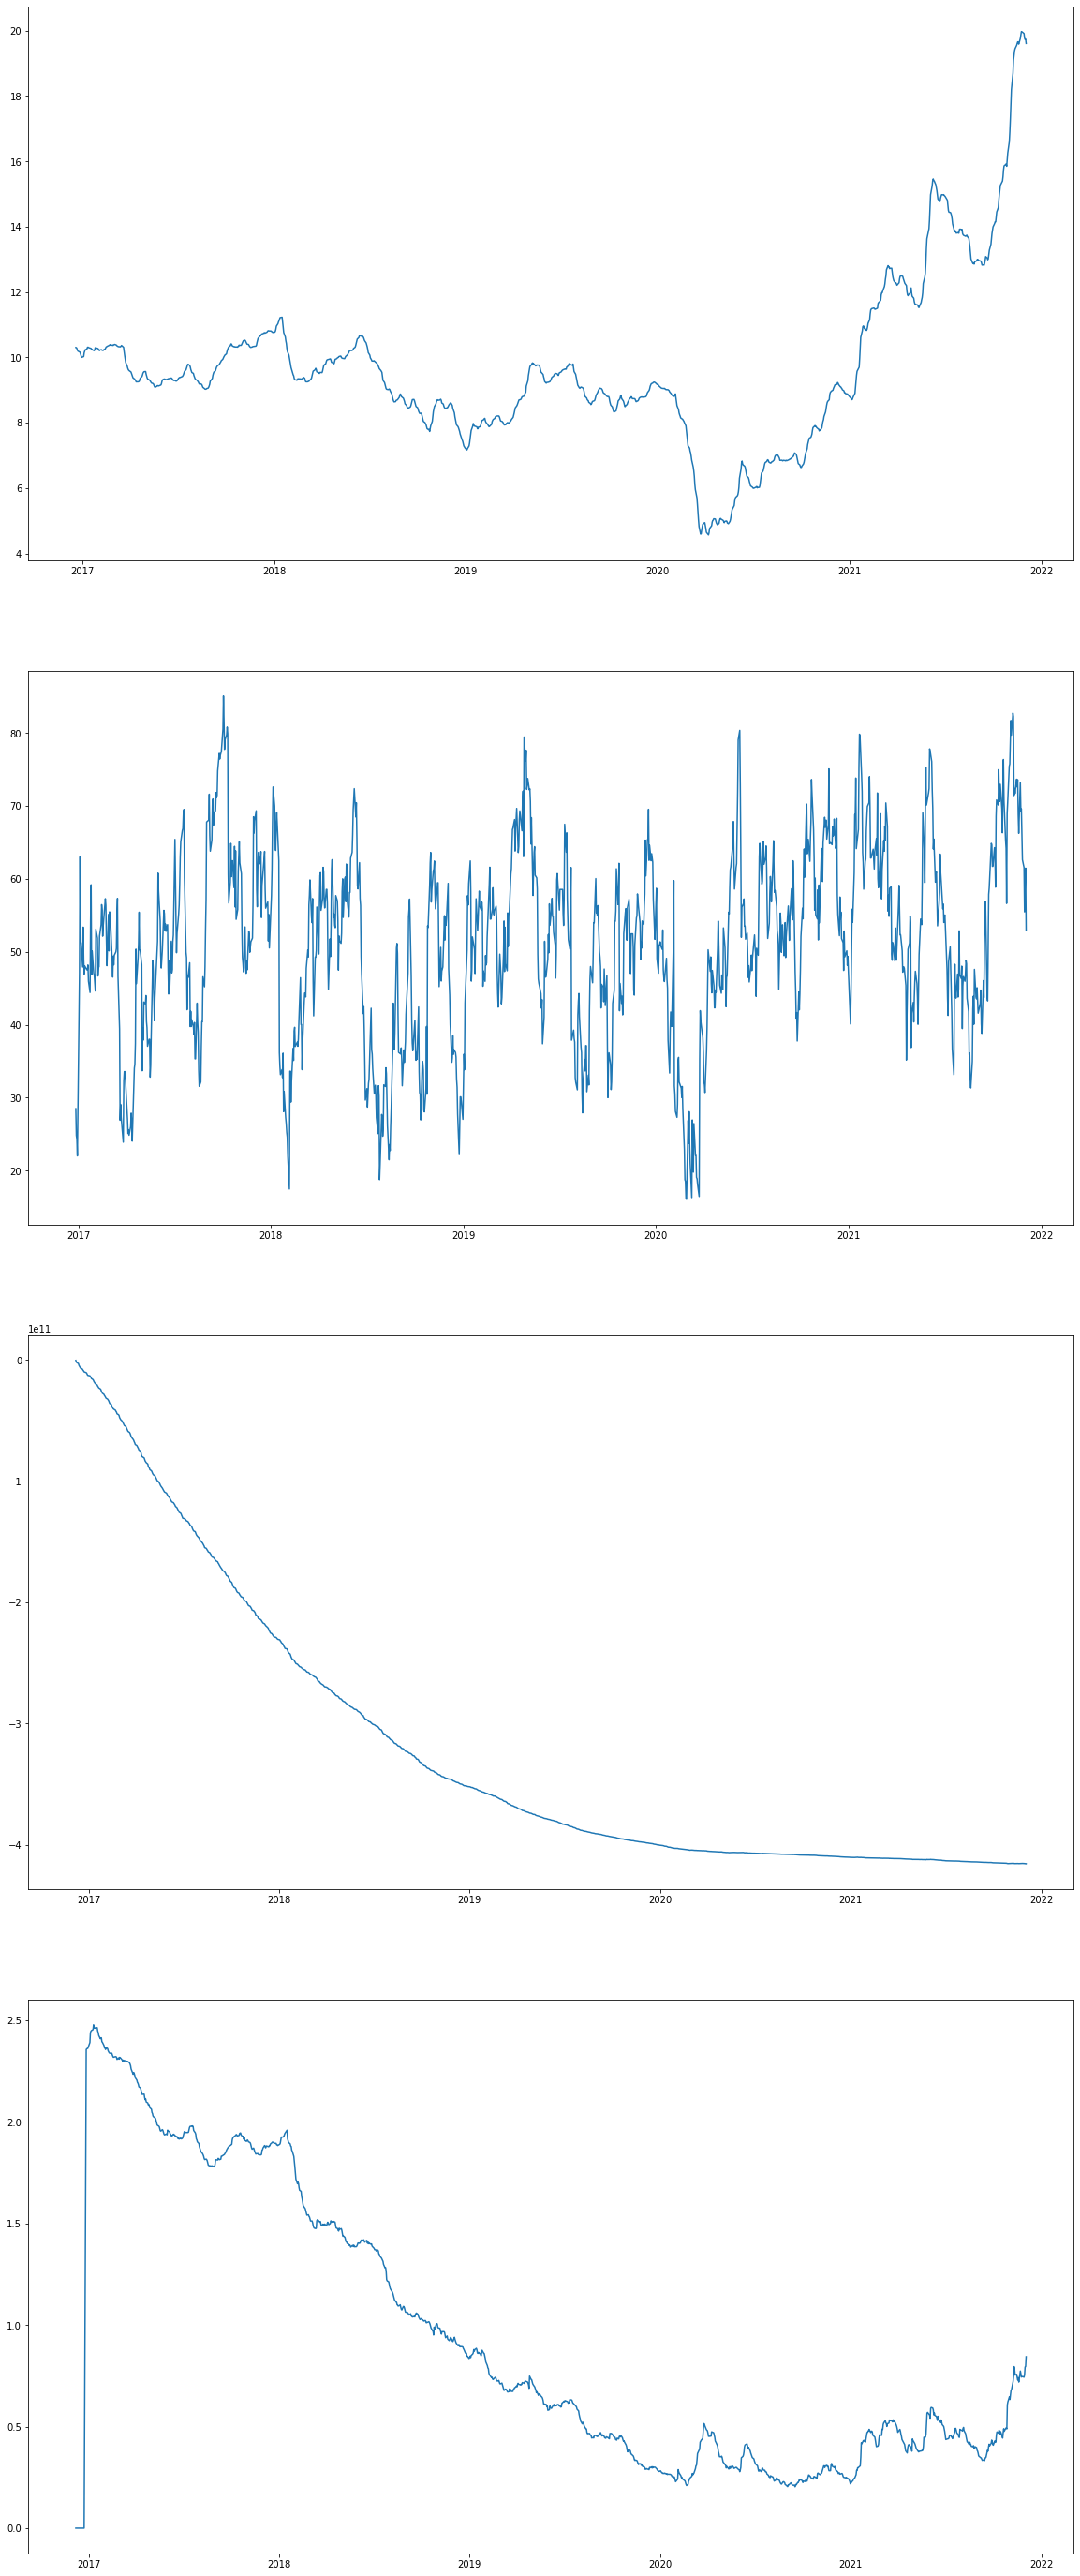

In [3]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error

def svr_linear(ticker, period):
    train_prepared, train_set_labels, test_set_features, test_set_labels = ticker_data_processing(ticker, period)
    
    svm_reg = LinearSVR(epsilon= .5)
    svm_reg.fit(train_prepared, train_set_labels)
    
    predictions = svm_reg.predict(test_set_features)
    print(predictions)
    
    scores = cross_val_score(svm_reg, train_prepared, train_set_labels, scoring="neg_mean_squared,erro", cv=10)
    
    rmse = np.sqrt(-scores)
    print("Scores:", rmse)
    print("Mean:", rmse.mean())
    print ("Standared deviation:", rmse.std())
    print("MAPE: ", mean_absolute_percentage_error(pred, train_set_labels))
    
svr_linear('F', '5y')